# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
######
#@title 1. Connect Colab to your google drive
######

%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')
#### change to the directory in your drive. 
%cd "/content/drive/MyDrive/MP3/Q1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MP3/Q1


In [2]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
from skimage.transform import ProjectiveTransform, warp

# Helper functions

In [3]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [4]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    # Create a list of matches
    matches = np.zeros((num_matches, 4))
    indices = np.argpartition(dist.ravel(), num_matches)[:num_matches]
    rows, cols = np.unravel_index(indices, dist.shape)
    idx=0
    for i,j in zip(rows, cols):
      matches[idx, :] =np.array([*kp1[i].pt, *kp2[j].pt])
      idx+=1  
    return matches


def ransac(matches, threshold=2, outlier_ratio=0.1):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    p,s = 0.99,4
    N = int(np.log(1 - p)/np.log(1 - (1 - outlier_ratio)**s))
    best_h_mat=None
    minimum_residual = np.inf
    X_src = matches[:, :2]
    X_dest = matches[:, 2:]
    homogeneous_src = np.hstack((X_src, np.ones((matches.shape[0], 1))))
    for i in range(N):
        sample = matches[np.random.choice(matches.shape[0], s, replace=False)]
        h_mat = compute_homography(sample)
        projected_image = np.dot(homogeneous_src, h_mat.T)
        projected_image =projected_image[:, :2] / projected_image[:, 2:]
        image_residual = np.sum((projected_image - X_dest)**2, axis=1)
        matched_outliers = matches[image_residual > threshold]         
        if matched_outliers.shape[0] / matches.shape[0] < outlier_ratio:
            best_residual = image_residual[image_residual <= threshold]
            matched_inliers = matches[image_residual <= threshold]
            best_h_mat = compute_homography(matched_inliers)
            return best_h_mat, matched_inliers, best_residual
        inlier_residual = np.mean(image_residual[image_residual <= threshold])
        if inlier_residual < minimum_residual:
            minimum_residual = inlier_residual
            best_inliers_indices = image_residual <= threshold
    matched_inliers = matches[best_inliers_indices]
    best_residual = image_residual[best_inliers_indices]
    best_h_mat = compute_homography(matched_inliers)
    return best_h_mat, matched_inliers, best_residual

    

def compute_homography(matches):
    """
    write your code to compute homography according to the matches
    """
    num_correspondences = matches.shape[0]
    
    # Construct A matrix
    H_mat = np.zeros((2*num_correspondences, 9))
    for i in range(num_correspondences):
        x1,y1 =matches[i][0],matches[i][1]
        x2 = matches[i][2]
        y2 = matches[i][3]
        H_mat[2*i,:] = np.array([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        H_mat[2*i+1,:] = np.array([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    H_mat = np.array(H_mat)    
    U, S, V = np.linalg.svd(H_mat)
    return V[-1, :].reshape((3, 3))


def warp_images(image1, image2,H_mat):
    """
    write your code to stitch images together according to the homography
    """
    # <YOUR CODE>
    transformed_coords = ProjectiveTransform(H_mat)
    height = image1.shape[0]
    width = image1.shape[1] + image2.shape[1]
    depth = image1.shape[2]
    stitched_img = np.zeros((height, width, depth), dtype = 'int')
    transform_img2 = warp(image2, transformed_coords, output_shape=(height,width,depth))
    transform_img2 = transform_img2 * 255.
    transform_img2 = transform_img2.astype('int')
    transform__img1 = np.zeros((height, width, depth), dtype = 'int')
    transform__img1[:,:image1.shape[1]] = image1
    for i in range(stitched_img.shape[0]):
        for j in range(stitched_img.shape[1]):
            if (transform_img2[i][j] != 0).all():
                stitched_img[i][j] = transform_img2[i][j]
            else:
                stitched_img[i][j] = transform__img1[i][j]
    return stitched_img



# Main functions

#### Load images

In [5]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

(300, 4)


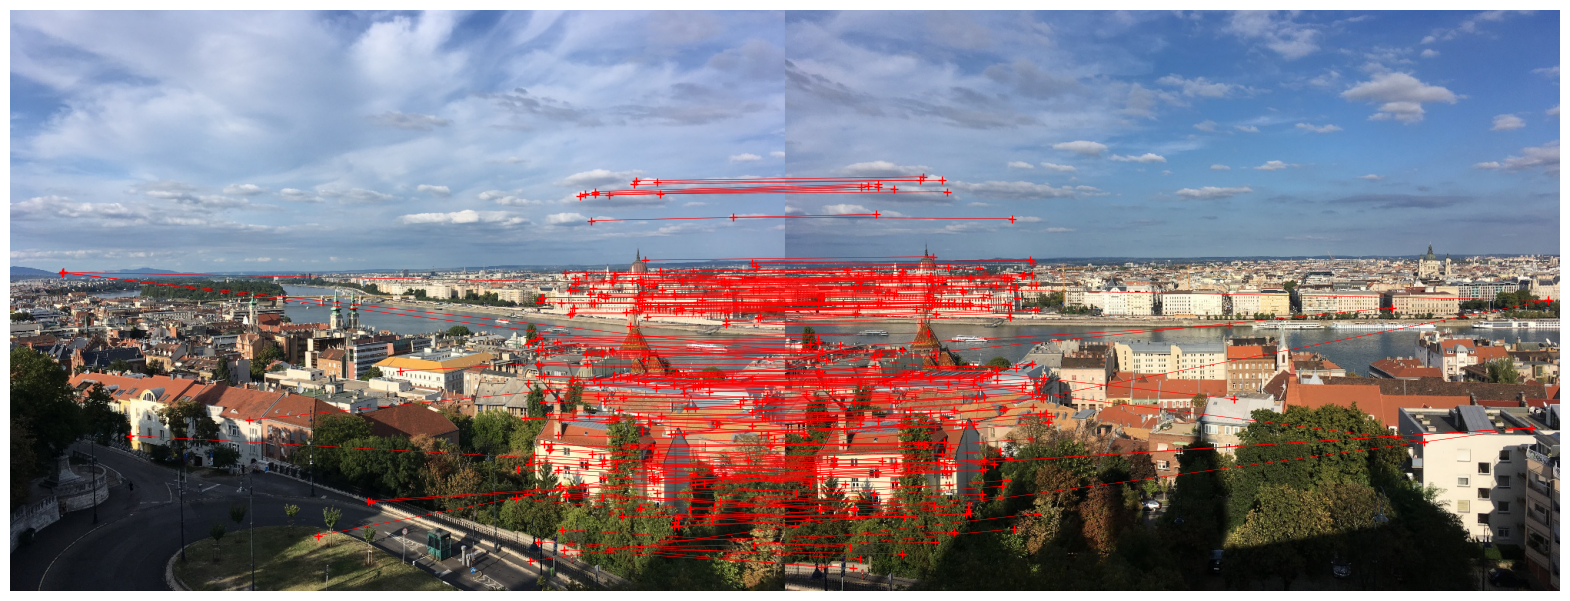

In [6]:
data = get_best_matches(img1, img2, 300)
print(data.shape)
data = np.unique(data, axis=0)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.pdf', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

In [7]:
# display the inlier matching, report the average residual
# <YOUR CODE>
best_h_mat, max_inliers, best_model_errors = ransac(data, threshold=80, outlier_ratio=0.04)
print("Average residual:", np.average(best_model_errors))
print(best_h_mat)
print("Inliers:", max_inliers)
fig.savefig('ransac_match.png', bbox_inches='tight')

Average residual: 16.22942027555401
[[ 1.45772221e-03  2.42004160e-05 -9.63505400e-01]
 [ 3.23951959e-04  1.26834559e-03 -2.67681297e-01]
 [ 9.75224039e-07 -3.97951146e-09  4.77935232e-04]]
Inliers: [[744.98815918 616.96502686 114.65337372 629.12628174]
 [750.04370117 590.92889404 119.64405823 600.64862061]
 [753.00445557 528.53289795 120.60138702 534.90789795]
 [756.46887207 577.91625977 125.29756165 585.87792969]
 [759.14312744 481.32559204 128.04171753 484.20898438]
 [764.53399658 502.07214355 134.38130188 504.74838257]
 [766.24456787 486.3576355  136.60757446 488.11392212]
 [768.86639404 633.44177246 140.16464233 640.4855957 ]
 [769.49993896 589.67468262 141.30586243 595.11480713]
 [770.98120117 608.10101318 142.30105591 613.92993164]
 [771.64550781 508.46121216 142.39759827 510.724823  ]
 [772.6418457  585.44873047 144.0821228  590.00805664]
 [778.34942627 700.85394287 152.2000885  707.4644165 ]
 [778.95404053 532.25976562 149.73466492 534.22119141]
 [781.15130615 654.1416626  154

In [8]:
print(data.shape, max_inliers.shape)

(275, 4) (158, 4)


#### Part (5) warp images to stitch them together

In [9]:
# display and report the stitching results
# <YOUR CODE>
im = warp_images(img1, img2, best_h_mat)
cv2.imwrite('stitched_images.jpg', im[:,:,::-1], [int(cv2.IMWRITE_JPEG_QUALITY), 90])

True

(243, 4)


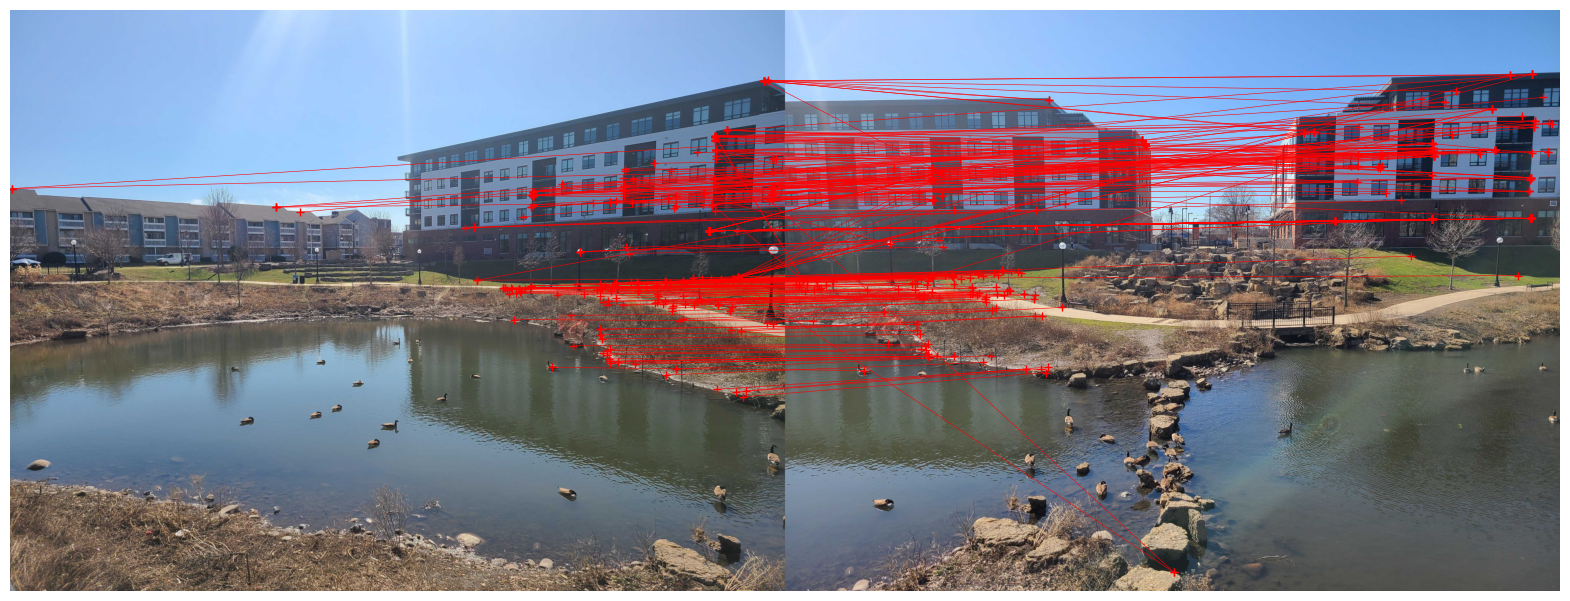

In [10]:
# Extra credit part: stitching three images
img1 = imread('./extra_credits/opt_01/park_left.jpg')
img2 = imread('./extra_credits/opt_01/park_center.jpg')
img3 = imread('./extra_credits/opt_01/park_right.jpg')

data1 = get_best_matches(img1, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data1)
fig.savefig('sift_match_extra1.png', bbox_inches='tight')
data1 = np.unique(data1, axis=0)
print(data1.shape)

In [11]:
print(img1.shape,img2.shape,img3.shape)

(1512, 2016, 3) (1512, 2016, 3) (1512, 2016, 3)


(258, 4)


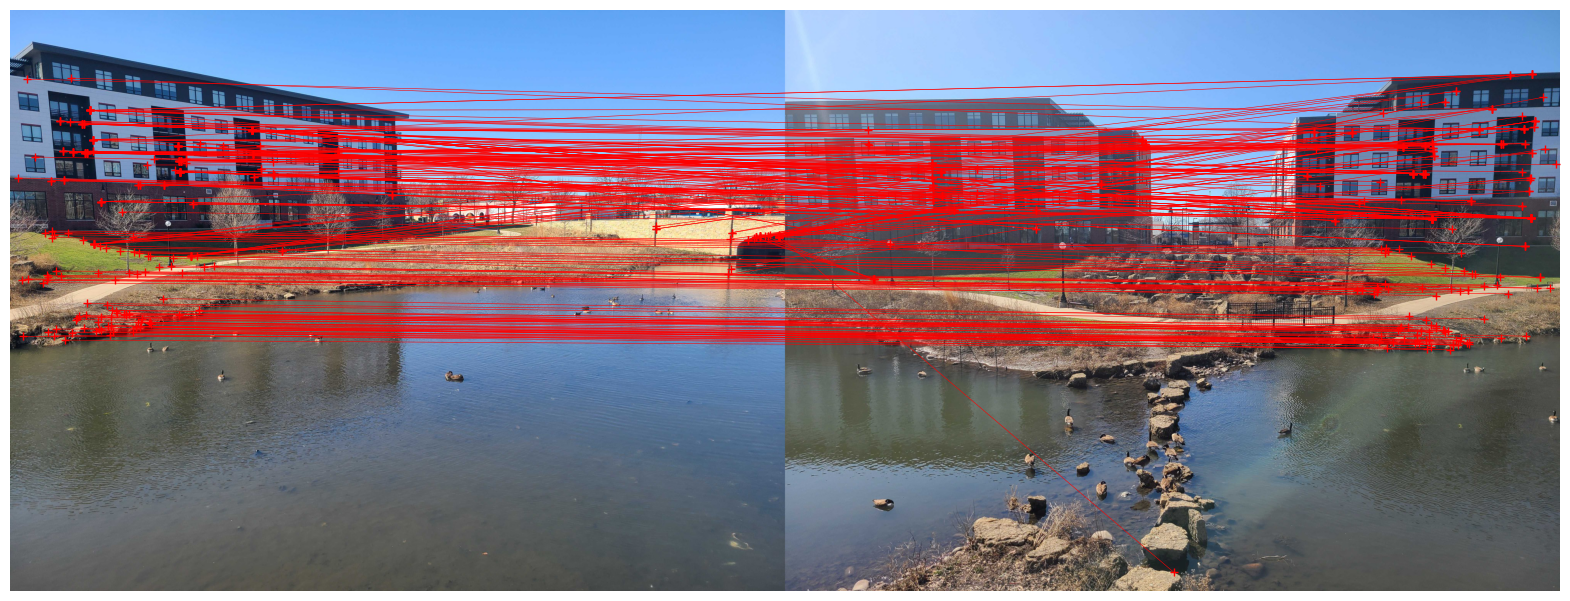

In [12]:
data2 = get_best_matches(img3, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img3, img2, data2)
fig.savefig('sift_match_extra3.png', bbox_inches='tight')
data2 = np.unique(data2, axis=0)
print(data2.shape)

In [13]:
homography1, max_inliers1, best_model_errors1 = ransac(data1, threshold=100, outlier_ratio=0.8)
print("Average residual of image 1:", np.average(best_model_errors1))
print("Inliers in image 1:", max_inliers1)
print(max_inliers1.shape)

Average residual of image 1: 16.88202720035208
Inliers in image 1: [[1282.33618164  723.29272461   26.85912895  715.2088623 ]
 [1287.91845703  723.82513428   35.93037033  715.52233887]
 [1291.87463379  728.03137207   41.46773148  720.50415039]
 [1298.27368164  738.00860596   50.50054169  732.12426758]
 [1303.63635254  723.98931885   57.61120224  715.0737915 ]
 [1304.42822266  724.96905518   57.94346237  716.31237793]
 [1315.94921875  735.82830811   74.86231232  728.77435303]
 [1323.09411621  725.8001709    83.75382233  716.60076904]
 [1326.87219238  733.53790283   88.41070557  726.11700439]
 [1329.29663086  731.70635986   91.9648819   723.22454834]
 [1339.79760742  725.9765625   106.69035339  716.05487061]
 [1353.93054199  717.10418701  123.68032837  705.68328857]
 [1422.89367676  740.22546387  212.335495    728.94329834]
 [1459.16467285  794.42382812  257.6630249   785.97735596]
 [1474.07141113  711.69458008  269.88052368  696.58758545]
 [1492.07543945  739.81829834  293.02139282  725

In [14]:
homography3, max_inliers3, best_model_errors3 = ransac(data2, threshold=60, outlier_ratio=0.9)
print("Average residual of image 3:", np.average(best_model_errors3))
print("Inliers in image 3:", max_inliers3)
print(max_inliers3.shape)

Average residual of image 3: 4.649273782807147
Inliers in image 3: [[  19.70966721  437.28707886 1506.45446777  497.51675415]
 [  30.68591881  701.97485352 1488.41174316  728.22808838]
 [  32.09104156  848.94537354 1478.55615234  855.58355713]
 [  45.08526993  699.8079834  1499.46508789  727.25970459]
 [  63.47027969  382.47741699 1546.2791748   446.34814453]
 [  85.4131546   709.27386475 1530.61938477  737.81005859]
 [  90.93108368  579.21612549 1550.62841797  622.55554199]
 [  95.57440186  690.09564209 1540.44812012  721.39263916]
 [  95.60263062  703.43017578 1539.19995117  732.81433105]
 [  97.18960571  837.58728027 1529.91369629  853.27600098]
 [  98.88980103  694.4487915  1542.52233887  725.46356201]
 [ 107.78205872  592.12683105 1559.88574219  632.99151611]
 [ 109.22121429  574.73297119 1562.31188965  619.39196777]
 [ 114.62656403  584.55224609 1567.35961914  627.28753662]
 [ 114.99420166  847.00952148 1543.71569824  863.63647461]
 [ 118.30142212  678.83892822 1559.71508789  712

In [16]:
import numpy as np
from skimage.transform import ProjectiveTransform, warp

def warp_three_images(img1, img2, img3, H_mat1, H_mat2):
    """
    Stitches three images together using their respective homography matrices.
    Assumes that img1 is the leftmost image, img2 is in the middle, and img3 is on the right.
    """
    
    # Define output shape of stitched image
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    h3, w3 = img3.shape[:2]
    max_h = max(h1, h2, h3)
    max_w = w1 + w2 + w3
    
    # Warp img2 and img3 using their respective homography matrices
    H1 = ProjectiveTransform(H_mat1)
    H2 = ProjectiveTransform(H_mat2)
    warped_img2 = warp(img2, H1, output_shape=(max_h, max_w))
    warped_img3 = warp(img3, H2, output_shape=(max_h, max_w))
    
    # Initialize output image
    stitched_img = np.zeros((max_h, max_w, 3), dtype=np.uint8)
    
    # Copy img1 into stitched image
    stitched_img[:h1, :w1] = img1
    
    # Copy warped img2 and img3 into stitched image
    for i in range(max_h):
        for j in range(w1, w1+w2):
            if (warped_img2[i][j-w1] != 0).all():
                stitched_img[i][j] = warped_img2[i][j-w1]
            if (warped_img3[i][j-w1-w2] != 0).all():
                stitched_img[i][j] = warped_img3[i][j-w1-w2]
    
    return stitched_img


In [18]:
# display and report the stitching results
# <YOUR CODE>
im = warp_three_images(img1, img2, img3, homography1, homography3)
# im = warp_images(ex1, ex2, H1)
# im = warp_images(ex3, ex2, H3)
cv2.imwrite('stitched_images_extra.png', im[:,:,::-1], [int(cv2.IMWRITE_JPEG_QUALITY), 90])

True